In [1]:
# Use pip to install imblearn
%pip install imblearn

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 17.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [2]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually

TARGET_COL = "Class"  # target column name
IS_SAMPLE = False  # if True, use only <SAMPLE_ROWS> rows of data for training, otherwise use all data
SAMPLE_ROWS = 100  # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = "Files"  # folder with data files
DATA_FILE = "file0.csv_exported.csv"  # data file name

EXPERIMENT_NAME = "ai-fraud"  # MLflow experiment name

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 10, Finished, Available)

In [3]:
if not IS_CUSTOM_DATA:
    # Download data files into lakehouse if not already there
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection"
    fname = "creditcard.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")


StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 11, Finished, Available)

Downloaded demo data files into lakehouse.


In [4]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 12, Finished, Available)

In [5]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 13, Finished, Available)

In [6]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", True)
    .load(f"{DATA_FOLDER}/{DATA_FILE}")
    .cache()
)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 14, Finished, Available)

In [7]:
display(df)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, b969f079-af37-4101-96e1-361b915245ed)

In [8]:
# Print dataset basic information
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 16, Finished, Available)

records read: 399999
Schema: 
root
 |-- Time: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- nameOrig: integer (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- Class: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [9]:
import pyspark.sql.functions as F

df_columns = df.columns
df_columns.remove(TARGET_COL)

# Ensure the TARGET_COL is the last column
df = df.select(df_columns + [TARGET_COL]).withColumn(TARGET_COL, F.col(TARGET_COL).cast("int"))

if IS_SAMPLE:
    df = df.limit(SAMPLE_ROWS)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 17, Finished, Available)

In [10]:
df_pd = df.toPandas()

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 18, Finished, Available)

In [11]:
# The distribution of classes in the dataset
print('No Frauds', round(df_pd['Class'].value_counts()[0]/len(df_pd) * 100,2), '% of the dataset')
print('Frauds', round(df_pd['Class'].value_counts()[1]/len(df_pd) * 100,2), '% of the dataset')

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 19, Finished, Available)

No Frauds 99.95 % of the dataset
Frauds 0.05 % of the dataset


StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 20, Finished, Available)

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

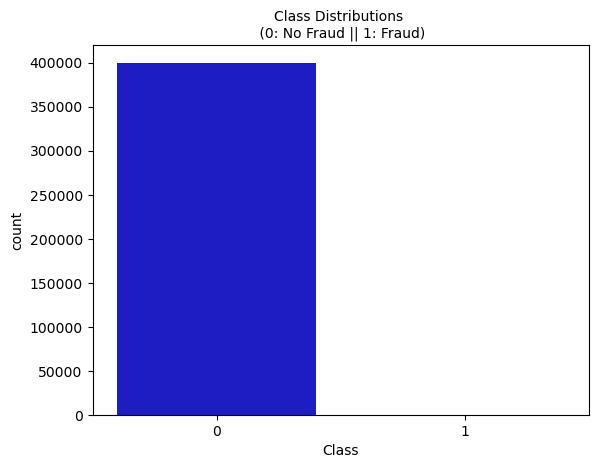

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df_pd, palette=colors) 
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 21, Finished, Available)

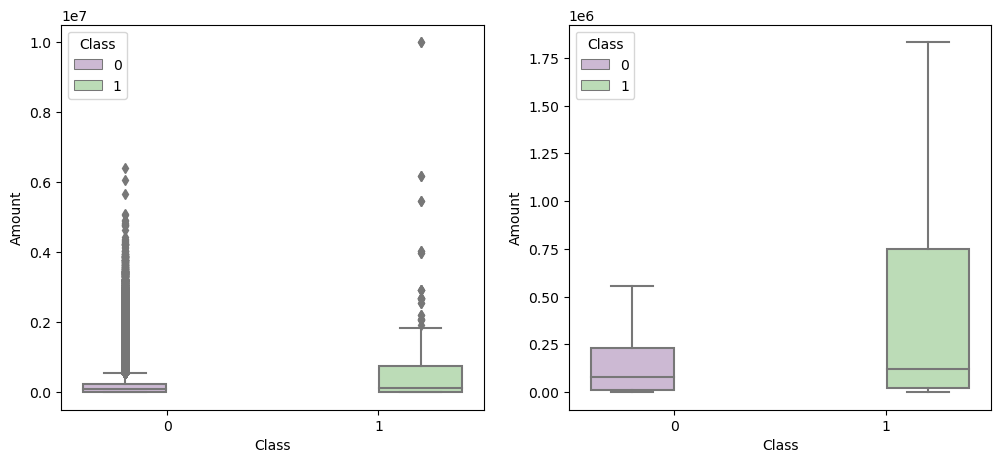

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=True) # Remove outliers from the plot
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=False) # Kepp outliers from the plot
plt.show()

In [14]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_pd, test_size=0.15)
feature_cols = [c for c in df_pd.columns.tolist() if c not in [TARGET_COL]]


StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 22, Finished, Available)

In [15]:
# Apply SMOTE to the training data
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

X = train[feature_cols]
y = train[TARGET_COL]
print("Original dataset shape %s" % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_res))

new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 23, Finished, Available)

Original dataset shape Counter({0: 339823, 1: 176})
Resampled dataset shape Counter({0: 339823, 1: 339823})


In [16]:
mlflow.autolog(exclusive=False)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 24, Finished, Available)

2024/02/28 17:50:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/28 17:50:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [17]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary") # imbalanced dataset
smote_model = lgb.LGBMClassifier(objective="binary") # balanced dataset

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 25, Finished, Available)

2024/02/28 17:50:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


In [18]:
# Train LightGBM for both imbalanced and balanced datasets and define the evaluation metrics
print("Start training with imbalanced data:\n")
with mlflow.start_run(run_name="raw_data") as raw_run:
    model = model.fit(
        train[feature_cols],
        train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

print(f"\n\nStart training with balanced data:\n")
with mlflow.start_run(run_name="smote_data") as smote_run:
    smote_model = smote_model.fit(
        new_train[feature_cols],
        new_train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 26, Finished, Available)

Start training with imbalanced data:

[LightGBM] [Info] Number of positive: 176, number of negative: 339823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 339999, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000518 -> initscore=-7.565696
[LightGBM] [Info] Start training from score -7.565696
[10]	valid_0's auc: 0.554042	valid_0's binary_logloss: 0.0279985
[20]	valid_0's auc: 0.492469	valid_0's binary_logloss: 0.0360141
[30]	valid_0's auc: 0.319299	valid_0's binary_logloss: 0.0759338
[40]	valid_0's auc: 0.432886	valid_0's binary_logloss: 0.0529818
[50]	valid_0's auc: 0.511124	valid_0's binary_logloss: 0.0490055
[60]	valid_0's auc: 0.565978	valid_0's binary_logloss: 0.0599353
[70]	valid_0's auc: 0.618373	valid_0's binary_logloss: 0.091001
[80]	valid_0

2024/02/28 17:50:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/02/28 17:50:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trus



Start training with balanced data:

[LightGBM] [Info] Number of positive: 339823, number of negative: 339823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 679646, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[10]	valid_0's auc: 0.993872	valid_0's binary_logloss: 0.253816
[20]	valid_0's auc: 0.994809	valid_0's binary_logloss: 0.127227
[30]	valid_0's auc: 0.995703	valid_0's binary_logloss: 0.0802917
[40]	valid_0's auc: 0.996668	valid_0's binary_logloss: 0.0556003
[50]	valid_0's auc: 0.997239	valid_0's binary_logloss: 0.0412431
[60]	valid_0's auc: 0.997505	valid_0's binary_logloss: 0.0332656
[70]	valid_0's auc: 0.997578	valid_0's binary_logloss: 0.0287061
[

2024/02/28 17:51:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/02/28 17:51:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trus

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 27, Finished, Available)

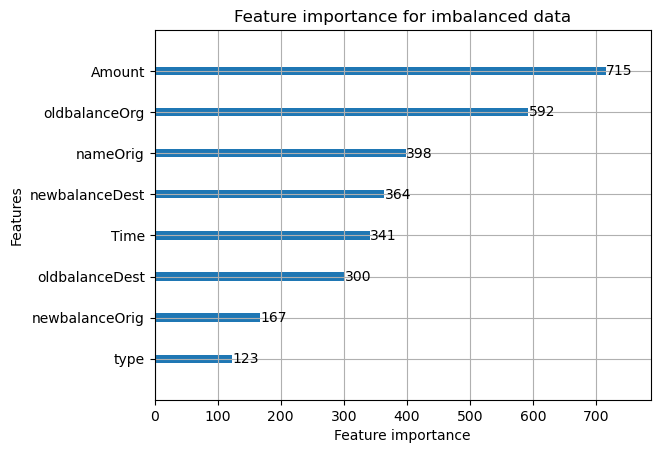

In [19]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    importance = lgb.plot_importance(
        model, title="Feature importance for imbalanced data"
    )
    importance.figure.savefig("feauture_importance.png")
    mlflow.log_figure(importance.figure, "feature_importance.png")

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 28, Finished, Available)

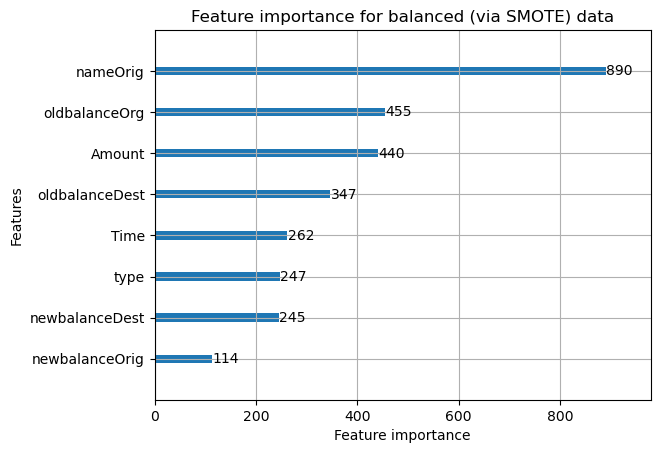

In [20]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    smote_importance = lgb.plot_importance(
        smote_model, title="Feature importance for balanced (via SMOTE) data"
    )
    smote_importance.figure.savefig("feauture_importance_smote.png")
    mlflow.log_figure(smote_importance.figure, "feauture_importance_smote.png")

In [21]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

def prediction_to_spark(model, test):
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test[TARGET_COL].tolist(), predictions.tolist()))
    dataColumns = [TARGET_COL, "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 29, Finished, Available)

In [22]:
predictions = prediction_to_spark(model, test)
smote_predictions = prediction_to_spark(smote_model, test)
predictions.limit(10).toPandas()

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 30, Finished, Available)

2024/02/28 17:51:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-02-28:17:51:27,248 WARNING  [tracking_store.py:153] log_inputs not supported
2024/02/28 17:51:28 WARNING mlf

,Class,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [23]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(predictions)

smote_metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(smote_predictions)
display(metrics)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 31, Finished, Available)

2024/02/28 17:51:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


SynapseWidget(Synapse.DataFrame, d33847cc-1add-481c-a923-b3021e137c54)

In [24]:
# Collect confusion matrix value
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
smote_cm = smote_metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 32, Finished, Available)

[[5.9892e+04 7.8000e+01]
 [2.7000e+01 3.0000e+00]]


StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 33, Finished, Available)

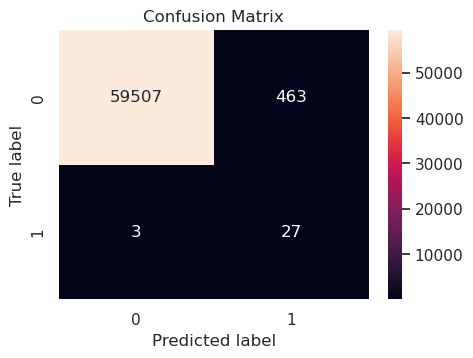

In [25]:
# Plot Confusion Matrix
import seaborn as sns

def plot(cm):
    """
    Plot the confusion matrix.
    """
    sns.set(rc={"figure.figsize": (5, 3.5)})
    ax = sns.heatmap(cm, annot=True, fmt=".20g")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

with mlflow.start_run(run_id=smote_run.info.run_id):
    ax = plot(smote_cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 34, Finished, Available)

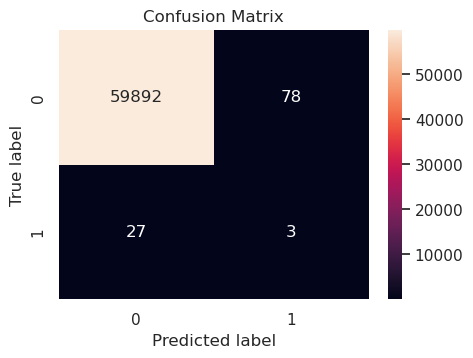

In [26]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    ax = plot(cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

In [30]:
# Register the model
registered_model_name = f"{EXPERIMENT_NAME}-lightgbm"

raw_model_uri = "runs:/{}/model".format(raw_run.info.run_id)
mlflow.register_model(raw_model_uri, registered_model_name)

smote_model_uri = "runs:/{}/model".format(smote_run.info.run_id)
mlflow.register_model(smote_model_uri, registered_model_name)

StatementMeta(, 9ba53e05-00e5-4cf3-84d7-52f8b7e9692e, 38, Finished, Available)

Successfully registered model 'aisample-fraud-lightgbm'.
2024/02/28 17:53:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-fraud-lightgbm, version 1
Created version '1' of model 'aisample-fraud-lightgbm'.
Registered model 'aisample-fraud-lightgbm' already exists. Creating a new version of this model...
2024/02/28 17:53:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-fraud-lightgbm, version 2
Created version '2' of model 'aisample-fraud-lightgbm'.


<ModelVersion: aliases=[], creation_timestamp=1709142823305, current_stage='None', description='', last_updated_timestamp=1709142823305, name='aisample-fraud-lightgbm', run_id='19b91659-7301-4daf-954c-618455f64eca', run_link='', source='abfss://9be248ad-b7ce-47d8-b68f-90229d0334fb@olssoutho6ljkytsv9sgz4y6.dfs.core.windows.net/c9ccf3b3-ade0-4784-86c9-6712a4f5605c/1125c85b-a3d5-4503-af2c-906ab520fca4/artifacts', status='READY', status_message='', tags={}, user_id='', version='2'>